In [1]:
import pandas as pd

# Cargar dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columnas = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
            "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

df = pd.read_csv(url, names=columnas)

# Ver las primeras filas
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [2]:
# Tamaño del dataset
print("Forma del dataset:", df.shape)

# Distribución del objetivo
print(df["Outcome"].value_counts())

# Estadísticas descriptivas
print(df.describe())


Forma del dataset: (768, 9)
Outcome
0    500
1    268
Name: count, dtype: int64
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160        

In [3]:
import numpy as np

columnas_con_ceros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df[columnas_con_ceros] = df[columnas_con_ceros].replace(0, np.nan)

# Ver cantidad de nulos
print(df.isnull().sum())


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [4]:
df[columnas_con_ceros] = df[columnas_con_ceros].fillna(df[columnas_con_ceros].mean())



In [5]:
# Separación de variables
from sklearn.model_selection import train_test_split

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [6]:
#Entrenamiento de un primer modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.63      0.67        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



In [7]:
#Validación cruzada + SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('modelo', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="f1")

print("F1 promedio con SMOTE + CV:", scores.mean())


F1 promedio con SMOTE + CV: 0.6554630748866553


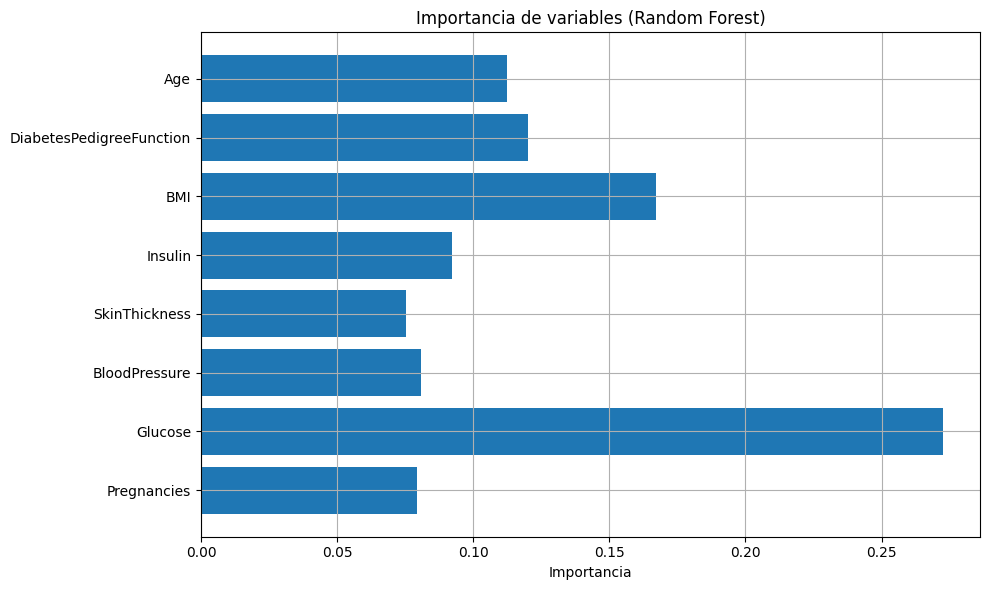

In [8]:
import matplotlib.pyplot as plt

importancias = modelo.feature_importances_
nombres = X.columns

# Visualizar
plt.figure(figsize=(10,6))
plt.barh(nombres, importancias)
plt.title("Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.grid(True)
plt.tight_layout()
plt.show()


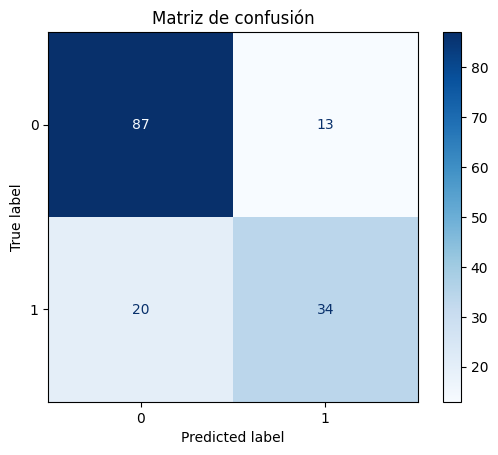

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, cmap='Blues')
plt.title("Matriz de confusión")
plt.show()


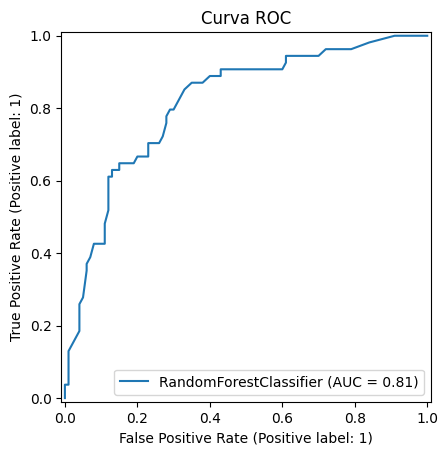

AUC Score: 0.8144444444444444


In [10]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

RocCurveDisplay.from_estimator(modelo, X_test, y_test)
plt.title("Curva ROC")
plt.show()

print("AUC Score:", roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]))


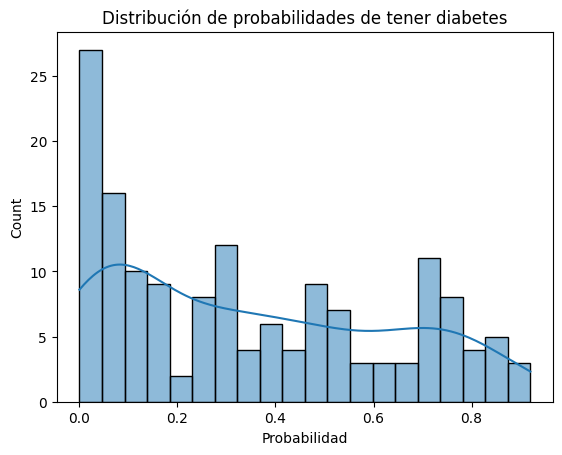

In [11]:
import seaborn as sns

probas = modelo.predict_proba(X_test)[:,1]

sns.histplot(probas, bins=20, kde=True)
plt.title("Distribución de probabilidades de tener diabetes")
plt.xlabel("Probabilidad")
plt.show()


In [12]:
import joblib

# Guardar modelo
joblib.dump(modelo, "modelo_diabetes.pkl")

# Cargar modelo luego
modelo_cargado = joblib.load("modelo_diabetes.pkl")


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parametros = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=parametros,
                    cv=5,
                    scoring="f1",
                    n_jobs=-1)

grid.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid.best_params_)
print("Mejor F1 en validación cruzada:", grid.best_score_)


Mejores parámetros encontrados: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mejor F1 en validación cruzada: 0.6535327983179713


In [14]:
# Random Search: búsqueda aleatoria
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

parametros = {
    "n_estimators": randint(50, 300),
    "max_depth": [None] + list(range(3, 15)),
    "min_samples_split": randint(2, 10)
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                   param_distributions=parametros,
                                   n_iter=20,
                                   cv=5,
                                   scoring="f1",
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train, y_train)

print("Mejores parámetros encontrados (random):", random_search.best_params_)
print("Mejor F1 en validación cruzada (random):", random_search.best_score_)


Mejores parámetros encontrados (random): {'max_depth': 12, 'min_samples_split': 9, 'n_estimators': 238}
Mejor F1 en validación cruzada (random): 0.63922668666108


In [15]:
# Pipeline de machine learning automatizado
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("modelo", RandomForestClassifier(random_state=42))
])

parametros = {
    "modelo__n_estimators": [50, 100],
    "modelo__max_depth": [None, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejor score con pipeline:", grid.best_score_)
print("Mejor modelo:", grid.best_estimator_)


Mejor score con pipeline: 0.654943318447269
Mejor modelo: Pipeline(steps=[('scaler', StandardScaler()),
                ('modelo', RandomForestClassifier(random_state=42))])
